In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [230]:
class Value:
    def __init__(self, data, _children=(), _op='', label= ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data a={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # other + self
        return self + other

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,  other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self*other

    def __truediv__(self, other):
        return self * other**-1         

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        t = math.exp(x)
        out = Value(t, (self, ), 'exp')
        def _backward():
            self.grad += out.data  * out.grad
        out.backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [231]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #, node_attr={'rankdir': 'TB'})

    nodes, edges  = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,  label = "{ %s |data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [232]:
a = Value(2)

b = 3 * a * a - 2
b

Value(data a=10)

In [234]:
sum([b],0.0)

Value(data a=10.0)

# Neural Net (MLP)

In [257]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b 
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [258]:
x = [2, 3]
n = Neuron(2)
n(x)

Value(data a=-0.7933483880660297)

In [377]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data a=0.014748633080406512)

In [378]:
n.parameters()

[Value(data a=0.7483422812113256),
 Value(data a=0.08493490167073126),
 Value(data a=-0.628437388847878),
 Value(data a=-0.11994947209199158),
 Value(data a=-0.3669038814447907),
 Value(data a=-0.10315982425410875),
 Value(data a=-0.5559014594376479),
 Value(data a=0.9637900729860216),
 Value(data a=-0.8361573514689637),
 Value(data a=-0.8720709413767427),
 Value(data a=0.584545338596264),
 Value(data a=-0.7994584497052679),
 Value(data a=-0.19332560518363406),
 Value(data a=-0.7663030676434468),
 Value(data a=0.43600838006602927),
 Value(data a=0.7510598233575685),
 Value(data a=-0.8557167424378314),
 Value(data a=-0.578626390693092),
 Value(data a=0.5103701099283366),
 Value(data a=-0.9384258100354219),
 Value(data a=0.4732759160897819),
 Value(data a=0.5282054125884121),
 Value(data a=0.529323820990633),
 Value(data a=-0.38046606603966415),
 Value(data a=0.3031168771569017),
 Value(data a=-0.429613957977244),
 Value(data a=-0.17200230564115082),
 Value(data a=0.26104279984862444),
 

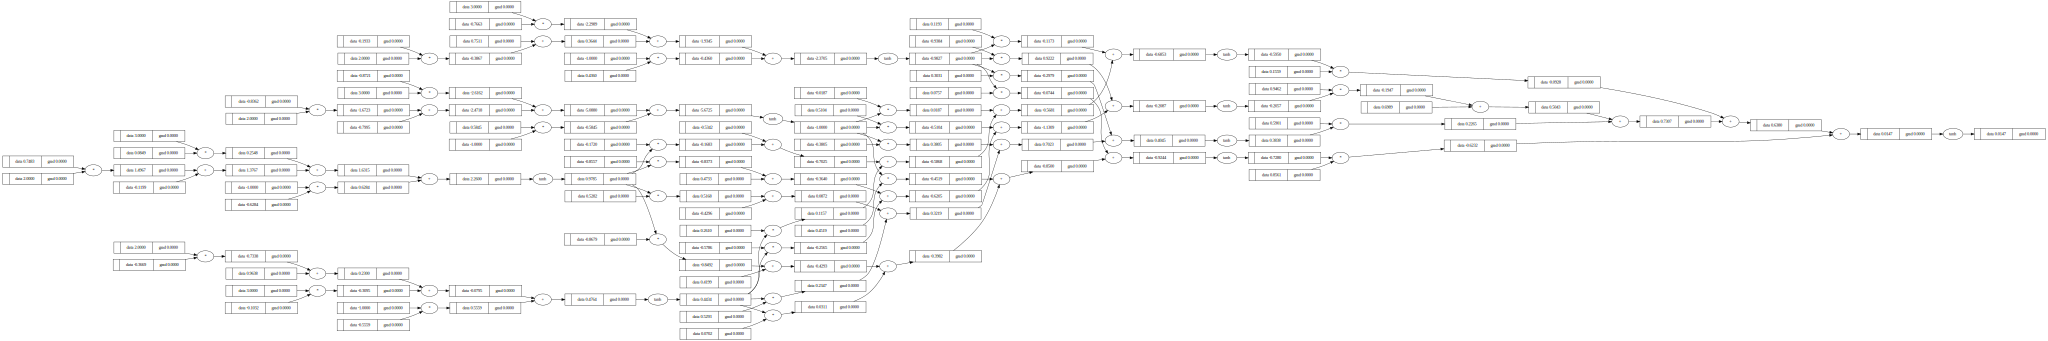

In [379]:
draw_dot(n(x))

In [380]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys= [1.0, -1.0, -1.0, 1.0] # Desired Target

# First Pred

In [381]:
ypred = [n(x) for x in xs]
ypred

[Value(data a=0.014748633080406512),
 Value(data a=-0.47315896720833783),
 Value(data a=0.6225907523206426),
 Value(data a=-0.16570595058362073)]

## Loss calculation

In [382]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data a=5.239952842592444)

## Manual Loss Calculation and backpropagation

In [363]:
loss.backward()

In [364]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [371]:
ypred

[Value(data a=1.0),
 Value(data a=-0.9999813416151794),
 Value(data a=-0.9999814666096265),
 Value(data a=1.0)]

## Looping the loss calculation

1. where backpropagation is done 20 times => range(20)
2. Step rate is 0.05

In [409]:
for k in range(20):
    #Loss
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #BAckward Pass
    for p in n.parameters():
        p.grad = 0.0 # Zero grad for all parameter before backward propagation
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.0014233280214340852
1 0.0014146130558618168
2 0.0014060003829573914
3 0.0013974882392379262
4 0.0013890749011851405
5 0.0013807586841256905
6 0.0013725379411488158
7 0.0013644110620597985
8 0.0013563764723680148
9 0.001348432632307987
10 0.0013405780358925145
11 0.0013328112099963052
12 0.0013251307134694175
13 0.0013175351362789
14 0.0013100230986780466
15 0.0013025932504017656
16 0.001295244269887684
17 0.00128797486352144
18 0.0012807837649057847
19 0.001273669734152264


In [410]:
ypred

[Value(data a=0.9837976225244772),
 Value(data a=-0.987735966148507),
 Value(data a=-0.9759484956554584),
 Value(data a=0.9831990681583769)]